**CHAP 7 : Data Preparation for dashboards and reports**

Note: Original dataset can be found here: https://www.kaggle.com/datasets/vivek468/superstore-dataset-final

# Notebook initialization

In [1]:
!wget https://raw.githubusercontent.com/datacorner/dataprep-handbook/main/superstore/samplesuperstore.csv

--2024-11-29 08:57:37--  https://raw.githubusercontent.com/datacorner/dataprep-handbook/main/superstore/samplesuperstore.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2278521 (2.2M) [text/plain]
Saving to: ‘samplesuperstore.csv.1’

samplesuperstore.cs 100%[===================>]   2.17M  --.-KB/s    in 0.07s   

2024-11-29 08:57:38 (30.8 MB/s) - ‘samplesuperstore.csv.1’ saved [2278521/2278521]



In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("samplesuperstore.csv")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [4]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [5]:
df.shape

(9994, 21)

# Data Profiling

In [6]:
!pip install ydata_profiling

In [7]:
from ydata_profiling import ProfileReport
from IPython.display import display, HTML

In [8]:
# Generate the profile report
profile = ProfileReport(df, title="Dataset Profiling Report")
# Display the report in the notebook
display(HTML(profile.to_html()))

Output hidden; open in https://colab.research.google.com to view.

# Foundational Techniques for Analytical Data Preparation

## Star Schema Preparation

In [9]:
data = df.copy()
data = data[ ['Order Date', 'Ship Date', 'Ship Mode',
       'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region',  'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'] ]

# Create dimension tables
def create_dimension_tables(df):
    # Customer Dimension
    customer_dim = df[['Customer Name', 'Segment', 'State']].drop_duplicates()
    customer_dim['Customer_Key'] = range(1, len(customer_dim) + 1)

    # Product Dimension
    product_dim = df[['Product Name', 'Category', 'Sub-Category']].drop_duplicates()
    product_dim['Product_Key'] = range(1, len(product_dim) + 1)

    # Date Dimension
    df['Order Date'] = pd.to_datetime(df['Order Date'])
    date_dim = pd.DataFrame({
        'Date': pd.date_range(start=df['Order Date'].min(), end=df['Order Date'].max()),
    })
    date_dim['Year'] = date_dim['Date'].dt.year
    date_dim['Month'] = date_dim['Date'].dt.month
    date_dim['Quarter'] = date_dim['Date'].dt.quarter
    date_dim['Date_Key'] = range(1, len(date_dim) + 1)

    return customer_dim, product_dim, date_dim

In [10]:
def create_fact_table(df, customer_dim, product_dim, date_dim):
    # Merge Customer Dimension Key
    fact_table = df.merge(customer_dim, on=['Customer Name', 'Segment', 'State'], how='left')

    # Merge Product Dimension Key
    fact_table = fact_table.merge(product_dim, on=['Product Name', 'Category', 'Sub-Category'], how='left')

    # Merge Date Dimension Key (for Order Date)
    fact_table = fact_table.merge(date_dim.rename(columns={'Date': 'Order Date'}), on='Order Date', how='left')

    # Selecting Fact Table Columns
    fact_table = fact_table[[
        'Customer_Key', 'Product_Key', 'Date_Key',  # Foreign keys
        'Sales', 'Quantity', 'Discount', 'Profit',  # Metrics
        'Ship Mode', 'Region', 'City', 'Country'   # Additional attributes
    ]]
    return fact_table

In [11]:
customer_dim, product_dim, date_dim = create_dimension_tables(data)

In [12]:
fact_table = create_fact_table(data, customer_dim, product_dim, date_dim)

In [13]:
fact_table.head()

,Customer_Key,Product_Key,Date_Key,Sales,Quantity,Discount,Profit,Ship Mode,Region,City,Country
0,1,1,1041,261.9600,2,0.00,41.9136,Second Class,South,Henderson,United States
1,1,2,1041,731.9400,3,0.00,219.5820,Second Class,South,Henderson,United States
2,2,3,892,14.6200,2,0.00,6.8714,Second Class,West,Los Angeles,United States
3,3,4,647,957.5775,5,0.45,-383.0310,Standard Class,South,Fort Lauderdale,United States
4,3,5,647,22.3680,2,0.20,2.5164,Standard Class,South,Fort Lauderdale,United States


In [14]:
customer_dim.head()

,Customer Name,Segment,State,Customer_Key
0,Claire Gute,Consumer,Kentucky,1
2,Darrin Van Huff,Corporate,California,2
3,Sean O'Donnell,Consumer,Florida,3
5,Brosina Hoffman,Consumer,California,4
12,Andrew Allen,Consumer,North Carolina,5


In [15]:
product_dim.head()

,Product Name,Category,Sub-Category,Product_Key
0,Bush Somerset Collection Bookcase,Furniture,Bookcases,1
1,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",Furniture,Chairs,2
2,Self-Adhesive Address Labels for Typewriters b...,Office Supplies,Labels,3
3,Bretford CR4500 Series Slim Rectangular Table,Furniture,Tables,4
4,Eldon Fold 'N Roll Cart System,Office Supplies,Storage,5


In [16]:
date_dim.head()

,Date,Year,Month,Quarter,Date_Key
0,2014-01-03,2014,1,1,1
1,2014-01-04,2014,1,1,2
2,2014-01-05,2014,1,1,3
3,2014-01-06,2014,1,1,4
4,2014-01-07,2014,1,1,5


## Slowly Changing Dimension (SCD) Handling

In [17]:
def handle_slowly_changing_dimension(df):
    # Example: Track changes in customer segment
    df['Change_Timestamp'] = pd.Timestamp.now()
    # Type 2 SCD: Create a history of changes
    scd_history = df.groupby('Customer ID').apply(lambda x: x.sort_values('Change_Timestamp').drop_duplicates('Segment', keep='last')).reset_index(drop=True)
    return scd_history

In [18]:
df_scd = handle_slowly_changing_dimension(df)
df_scd.shape

<ipython-input-17-1e29415997d5>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  scd_history = df.groupby('Customer ID').apply(lambda x: x.sort_values('Change_Timestamp').drop_duplicates('Segment', keep='last')).reset_index(drop=True)


(793, 22)

In [19]:
df[ df["Customer ID"] == "LC-16930" ].shape

(14, 22)

In [20]:
df_scd[ df_scd["Customer ID"] == "LC-16930" ]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Change_Timestamp
452,7210,CA-2016-143476,9/11/2016,9/13/2016,First Class,LC-16930,Linda Cazamias,Corporate,United States,Phoenix,...,West,OFF-PA-10001667,Office Supplies,Paper,Great White Multi-Use Recycled Paper (20Lb. an...,9.568,2,0.2,2.99,2024-11-29 08:58:44.545486


## Creating Derived Metrics

### Calculate the average Profit Margin per customer

In [21]:
data = df.copy()
data['Profit_Margin'] = data['Profit'] / data['Sales'] * 100
customer_ltv = data.groupby('Customer ID').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Order ID': 'count'
}).rename(columns={'Order ID': 'Purchase_Frequency'})

# Calculate the average Profit Margin per customer
customer_ltv['Profit_Margin'] = (data.groupby('Customer ID')['Profit_Margin']
                                  .mean().fillna(0))  # Handle potential NaN values

# Calculate Customer Lifetime Value (LTV)
customer_ltv['Customer_LTV'] = (
    customer_ltv['Sales'] *
    (1 + customer_ltv['Profit_Margin'] / 100) *
    customer_ltv['Purchase_Frequency']
)
customer_ltv.head()

,Sales,Profit,Purchase_Frequency,Profit_Margin,Customer_LTV
Customer ID,,,,,
AA-10315,5563.560,-362.8825,11,26.500000,77416.937400
AA-10375,1056.390,277.3824,15,31.900000,20900.676150
AA-10480,1790.512,435.8274,12,33.083333,28594.476640
AA-10645,5086.935,857.8033,18,24.414255,113919.700712
AB-10015,886.156,129.3465,6,10.541667,5877.429670


### Calculate the Quarterly Sales Ranking per Category

In [22]:
data = df.copy()
data['Order Date'] = pd.to_datetime(data['Order Date'])
quarterly_sales = data.groupby([
    pd.Grouper(key='Order Date', freq='Q'),
    'Category'
])['Sales'].sum().reset_index()

quarterly_sales['Sales_Rank'] = quarterly_sales.groupby('Order Date')['Sales'].rank(method='dense', ascending=False)
quarterly_sales.head()

<ipython-input-22-eb897e7f9dcf>:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  pd.Grouper(key='Order Date', freq='Q'),


,Order Date,Category,Sales,Sales_Rank
0,2014-03-31,Furniture,22656.1390,2.0
1,2014-03-31,Office Supplies,14528.6830,3.0
2,2014-03-31,Technology,37262.9740,1.0
3,2014-06-30,Furniture,28063.7496,2.0
4,2014-06-30,Office Supplies,31243.7350,1.0


# Advanced Analytical Data Preparation Techniques

## Time-Based Data Preparation

### Handle Missing Time Points
* Ensures a continuous time series
* Fills gaps in the data
* Creates a complete daily timeline
* Uses techniques like forward filling to maintain data continuity

In [23]:
data = df.copy()
# Convert the 'Order Date' column to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'])
# Set 'Order Date' as the index
data.set_index('Order Date', inplace=True)
# Sort the index to ensure it is in chronological order
data.sort_index(inplace=True)

# Generate a complete daily timeline
daily_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
# Aggregate data by summing numeric columns and taking the first value for non-numeric columns
data = data.groupby('Order Date').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Ship Date': 'first',
    'Category': 'first'
})
# Reindex the dataset to include all days
data = data.reindex(daily_index)
data.index.name = 'Order Date'
data.head()

,Sales,Profit,Ship Date,Category
Order Date,,,,
2014-01-03,16.448,5.5512,1/7/2014,Office Supplies
2014-01-04,288.060,-65.9901,1/8/2014,Office Supplies
2014-01-05,19.536,4.8840,1/12/2014,Office Supplies
2014-01-06,4407.100,1358.0524,1/10/2014,Office Supplies
2014-01-07,87.158,-71.9621,1/12/2014,Furniture


In [24]:
import matplotlib.pyplot as plt

def plot_datapoints(datastore, datastore_filled):
    # Filter the data for January 2016
    datastore = datastore[(datastore.index.year == 2016) & (datastore.index.month == 1)]
    datastore_filled = datastore_filled[(datastore_filled.index.year == 2016) & (datastore_filled.index.month == 1)]

    # Identify missing data points before and after forward filling
    missing_before = datastore['Sales'].isna()
    missing_after = datastore_filled['Sales'].isna()

    # Create the figure and subplots
    plt.figure(figsize=(12, 8))

    # Plot original data (before filling)
    plt.subplot(3, 1, 1)
    datastore['Sales'].plot(marker='o', linestyle='-', title='Before Filling Missing Time Points')
    plt.ylabel('Sales')

    # Plot the added data points (after filling missing time points)
    plt.subplot(3, 1, 2)
    filled_points = datastore_filled.index[datastore['Sales'].isna() & datastore_filled['Sales'].notna()]
    plt.title('Added Time Data Points')
    plt.scatter(filled_points, datastore_filled.loc[filled_points, 'Sales'], color='red', label='Filled Points')
    plt.ylabel('Sales')

    # Plot the data after filling missing time points
    plt.subplot(3, 1, 3)
    datastore_filled['Sales'].plot(marker='o', linestyle='-', title='After Filling Missing Time Points')
    plt.ylabel('Sales')

    # Set the same X and Y axis scales for all plots
    min_x = min(datastore.index.min(), datastore_filled.index.min())
    max_x = max(datastore.index.max(), datastore_filled.index.max())

    # Apply the same X limits to all subplots
    for ax in plt.gcf().get_axes():
        ax.set_xlim(min_x, max_x)

    # Set Y limits (same as before)
    min_y = min(datastore['Sales'].min(), datastore_filled['Sales'].min())
    max_y = max(datastore['Sales'].max(), datastore_filled['Sales'].max())
    for ax in plt.gcf().get_axes():
        ax.set_ylim(min_y, max_y)

    # Add a legend to the middle plot
    plt.subplot(3, 1, 2).legend(loc='upper left')

    # Tighten the layout and show the plot
    plt.tight_layout()
    plt.show()

    # Print the number of added points
    print("Number of added points: {}".format(len(filled_points)))


Option 1: Forward Fill

<ipython-input-25-a3e869a9c83c>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  datastore_ffill = data.fillna(method='ffill')


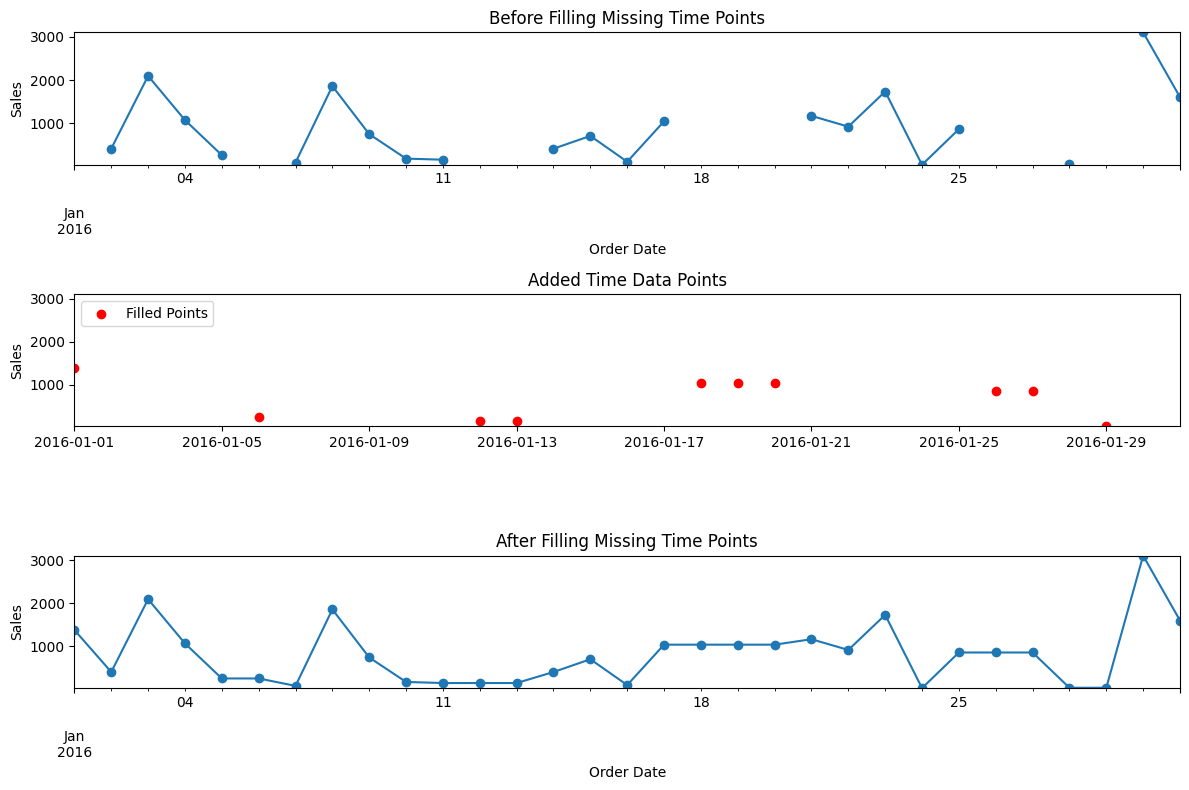

Number of added points: 10


In [25]:
# Fill missing data using forward filling
datastore_ffill = data.fillna(method='ffill')
plot_datapoints(data, datastore_ffill)

Option 2: Backward Fill

<ipython-input-26-8b8c8e5b7e4d>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  datastore_bfill = data.fillna(method='bfill')


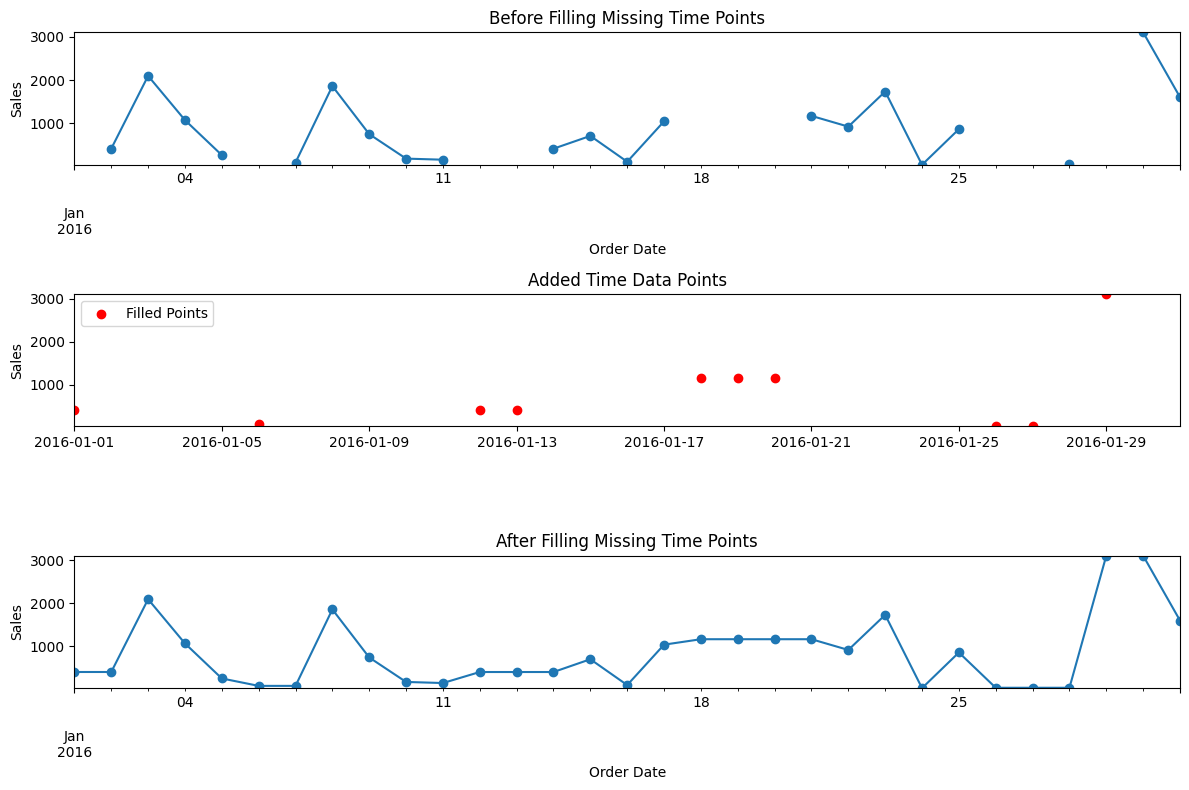

Number of added points: 10


In [26]:
# Fill missing data using backward filling
datastore_bfill = data.fillna(method='bfill')
plot_datapoints(data, datastore_bfill)

Option 3: Linear Interpolation

<ipython-input-27-1ac2241bf3b5>:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  datastore_linear = data.interpolate(method='linear')


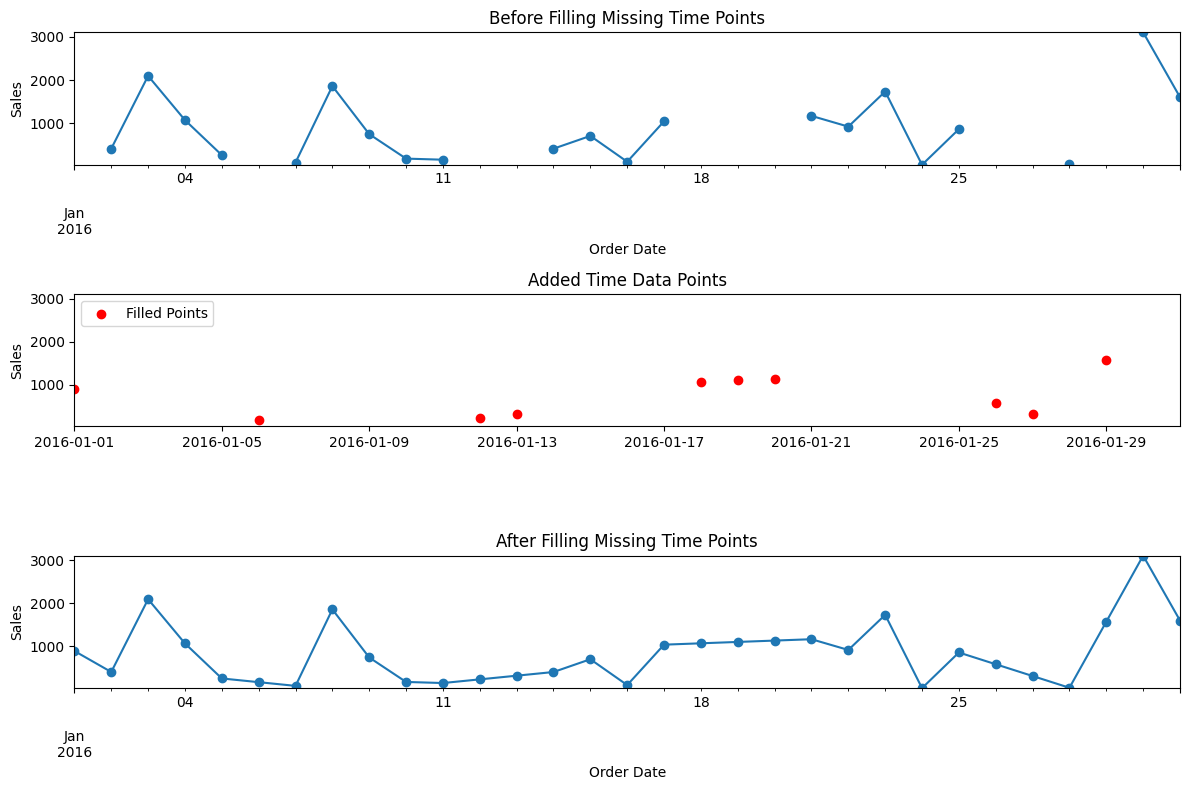

Number of added points: 10


In [27]:
# Linearly interpolate missing data
datastore_linear = data.interpolate(method='linear')
plot_datapoints(data, datastore_linear)

### Seasonal decomposition of the time series

Basic Date Conversion.
* Transforms "Order Date" strings into a standardized datetime format
* Ensures data can be analyzed chronologically
* Prepares data for time-based calculations

In [28]:
data = df.copy()

# Convert Order Date to datetime
data['Order Date'] = pd.to_datetime(df['Order Date'])

# Display date range to confirm conversion
print("Date Range:", data['Order Date'].min(), "to", data['Order Date'].max())

Date Range: 2014-01-03 00:00:00 to 2017-12-30 00:00:00


Daily Aggregations
* Summarizes transaction-level data into daily totals
* Calculates key metrics like total sales, profit, and transaction count
* Reduces data complexity while preserving essential information

In [29]:
# Group by Order Date and aggregate key metrics
daily_sales = data.groupby('Order Date').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Order ID': 'count'
}).rename(columns={'Order ID': 'Transaction_Count'})

# Display first few rows of daily aggregations
daily_sales.head()

,Sales,Profit,Transaction_Count
Order Date,,,
2014-01-03,16.448,5.5512,1
2014-01-04,288.060,-65.9901,3
2014-01-05,19.536,4.8840,1
2014-01-06,4407.100,1358.0524,9
2014-01-07,87.158,-71.9621,2


Create Time-Based Features Function
* Creates advanced temporal features. Generates:
  * Rolling averages (7-day and 30-day)
  * Exponential weighted moving averages
  * Year-over-year percentage changes
* Helps identify trends and patterns beyond raw daily numbers

In [30]:
# Generate advanced time-based features for a time series
def create_time_features(series):
    return pd.DataFrame({
        # Rolling window means. calculates the 7-day and 30-day moving average of the time series data
        'Rolling_7D_Mean': series.rolling(window=7).mean(),
        'Rolling_30D_Mean': series.rolling(window=30).mean(),
        # Exponential Weighted Moving Average
        'Exponential_Weighted_Mean': series.ewm(span=30).mean(),
        # Year-over-Year Percentage Change
        'Year_Over_Year_Change': series.pct_change(periods=365) * 100
    })

# Apply time features to Sales column
time_features = create_time_features(daily_sales['Sales'])

# Add these features to daily_sales
daily_sales = pd.concat([daily_sales, time_features], axis=1)

# Display the updated dataframe
daily_sales

,Sales,Profit,Transaction_Count,Rolling_7D_Mean,Rolling_30D_Mean,Exponential_Weighted_Mean,Year_Over_Year_Change
Order Date,,,,,,,
2014-01-03,16.4480,5.5512,1,NaN,NaN,16.448000,NaN
2014-01-04,288.0600,-65.9901,3,NaN,NaN,156.780867,NaN
2014-01-05,19.5360,4.8840,1,NaN,NaN,107.949946,NaN
2014-01-06,4407.1000,1358.0524,9,NaN,NaN,1292.522451,NaN
2014-01-07,87.1580,-71.9621,2,NaN,NaN,1018.272855,NaN
...,...,...,...,...,...,...,...
2017-12-26,814.5940,61.1202,4,3090.578286,3302.718267,3098.890901,-83.524571
2017-12-27,177.6360,-31.9742,2,3061.992571,3140.367067,2910.422843,-96.385794
2017-12-28,1657.3508,253.1188,19,2992.908400,3141.670293,2829.579485,-43.725870


Seasonal Decomposition
* Breaks down time series into core components
* Separates data into:
  * Trend (long-term movement)
  * Seasonal patterns
  * Random variations
* Reveals underlying structural patterns in the data

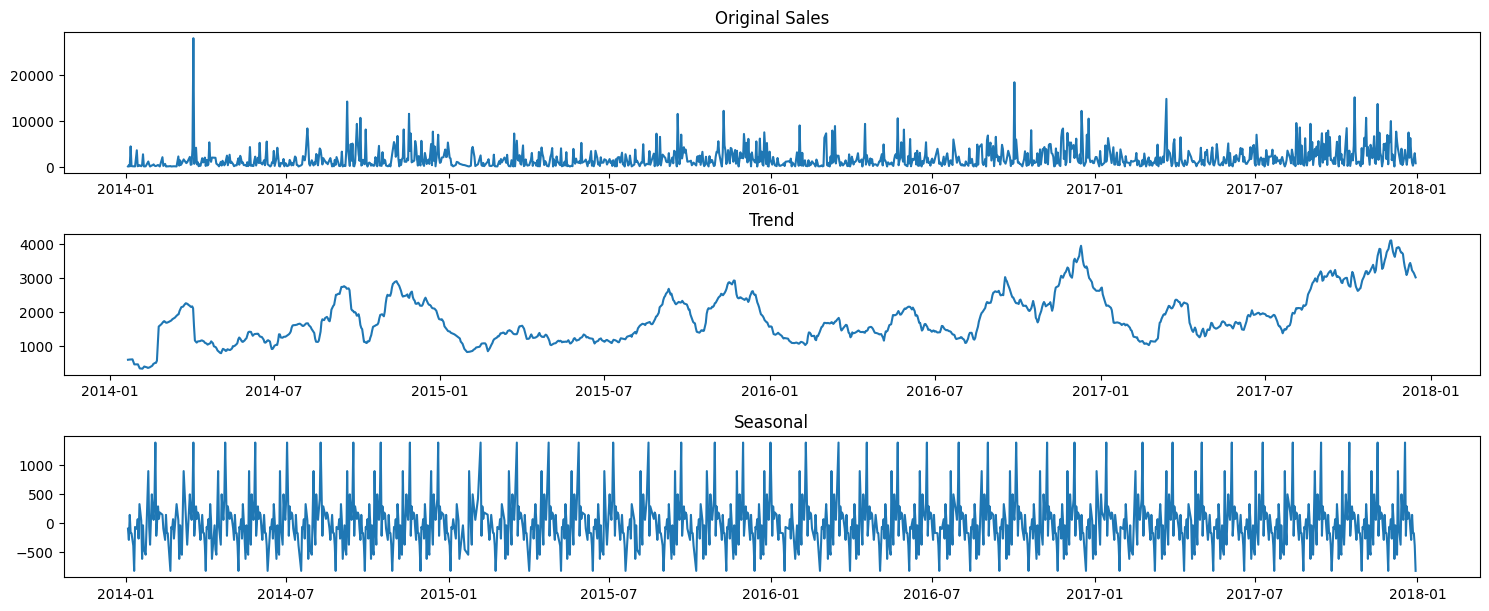

In [31]:
# Import seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Perform seasonal decomposition
decomposition = seasonal_decompose(daily_sales['Sales'], period=30)

# Add seasonal and trend components
daily_sales['Seasonal_Component'] = decomposition.seasonal
daily_sales['Trend_Component'] = decomposition.trend

# Visualization of decomposition
plt.figure(figsize=(15,8))

plt.subplot(411)
plt.title('Original Sales')
plt.plot(daily_sales.index, daily_sales['Sales'])

plt.subplot(412)
plt.title('Trend')
plt.plot(daily_sales.index, daily_sales['Trend_Component'])

plt.subplot(413)
plt.title('Seasonal')
plt.plot(daily_sales.index, daily_sales['Seasonal_Component'])

plt.tight_layout()
plt.show()

The charts presented in the image show a time series decomposition of the sales data into three components: Original Sales, Trend, and Seasonal.

* Original Sales: This chart shows the raw sales data over time, which displays significant volatility with noticeable spikes. This suggests irregular fluctuations or outliers in the data, possibly caused by specific events or promotions.
* Trend: The trend chart highlights the general upward or downward movement in the data. It indicates that, overall, sales have been increasing over time, but there are periodic dips and rises within this longer-term trend. This suggests that factors influencing sales, such as market demand or business growth, have contributed to a positive trajectory.
* Seasonal: The seasonal chart reveals repetitive patterns at regular intervals, typically corresponding to a specific period (e.g., weekly, monthly). This indicates that the sales are influenced by regular seasonal effects, such as holidays, special events, or cyclical business activities, that occur consistently over time.

The decomposition suggests that the sales data exhibits a strong upward trend, possibly driven by business growth or increased demand, alongside recurring seasonal patterns. The volatility in the original sales chart points to the presence of short-term anomalies or promotional events, which can be filtered out when analyzing underlying trends and seasonal behaviors. Understanding these components can help in forecasting and in planning for future sales strategies, especially for addressing seasonal fluctuations or smoothing out irregular spikes.

## Cohort analysis

**Goal**  
Analyze customer retention by observing the purchasing behavior of cohorts in 2017. Specifically, identify how many customers from each monthly cohort return to make subsequent purchases in later months. Cohort analysis involves grouping customers based on their first purchase month (the cohort) and tracking their retention in subsequent months.  

**This can help answer questions like:**
* Are newer customers more or less likely to return than older cohorts?
* Is retention improving over time?

**Steps**
* Group customers into cohorts based on their first purchase month.
* Calculate retention by determining the number of customers who make repeat purchases in each subsequent month.
* Visualize the retention rates using a heatmap.

**Step 1: we prepare the cohorts**

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns

data = df.copy()

# Convert 'Order Date' to datetime format
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%m/%d/%Y')

data = data[data['Order Date'].dt.year == 2017]

# Create Cohort Group (First Purchase Month by customer)
customer_first_purchase = data.groupby('Customer ID')['Order Date'].min()
data['Cohort_Group'] = data['Customer ID'].map(customer_first_purchase)

# Extract Cohort Month and Order Month
data['Cohort_Month'] = data['Cohort_Group'].dt.to_period('M')  # Converts to Period (Month)
data['Order_Month'] = data['Order Date'].dt.to_period('M')     # Converts to Period (Month)

data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Change_Timestamp,Cohort_Group,Cohort_Month,Order_Month
12,13,CA-2017-114412,2017-04-15,4/20/2017,Standard Class,AA-10480,Andrew Allen,Consumer,United States,Concord,...,Paper,Xerox 1967,15.552,3,0.2,5.4432,2024-11-29 08:58:44.545486,2017-04-15,2017-04,2017-04
23,24,US-2017-156909,2017-07-16,7/18/2017,Second Class,SF-20065,Sandra Flanagan,Consumer,United States,Philadelphia,...,Chairs,"Global Deluxe Stacking Chair, Gray",71.372,2,0.3,-1.0196,2024-11-29 08:58:44.545486,2017-07-16,2017-07,2017-07
34,35,CA-2017-107727,2017-10-19,10/23/2017,Second Class,MA-17560,Matt Abelman,Home Office,United States,Houston,...,Paper,Easy-staple paper,29.472,3,0.2,9.9468,2024-11-29 08:58:44.545486,2017-10-19,2017-10,2017-10
41,42,CA-2017-120999,2017-09-10,9/15/2017,Standard Class,LC-16930,Linda Cazamias,Corporate,United States,Naperville,...,Phones,Panasonic Kx-TS550,147.168,4,0.2,16.5564,2024-11-29 08:58:44.545486,2017-06-10,2017-06,2017-09
43,44,CA-2017-139619,2017-09-19,9/23/2017,Standard Class,ES-14080,Erin Smith,Corporate,United States,Melbourne,...,Storage,"Advantus 10-Drawer Portable Organizer, Chrome ...",95.616,2,0.2,9.5616,2024-11-29 08:58:44.545486,2017-02-24,2017-02,2017-09


Let's look at a specific customer (Linda Cazamias) who have ordered 3 times in 2017 (June, september and november)

In [34]:
data[ data["Customer ID"] == "LC-16930" ]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Change_Timestamp,Cohort_Group,Cohort_Month,Order_Month
41,42,CA-2017-120999,2017-09-10,9/15/2017,Standard Class,LC-16930,Linda Cazamias,Corporate,United States,Naperville,...,Phones,Panasonic Kx-TS550,147.168,4,0.2,16.5564,2024-11-29 08:58:44.545486,2017-06-10,2017-06,2017-09
2171,2172,US-2017-137491,2017-11-19,11/25/2017,Standard Class,LC-16930,Linda Cazamias,Corporate,United States,San Angelo,...,Chairs,"Lifetime Advantage Folding Chairs, 4/Carton",305.312,2,0.3,-8.7232,2024-11-29 08:58:44.545486,2017-06-10,2017-06,2017-11
5218,5219,CA-2017-167080,2017-06-10,6/14/2017,Standard Class,LC-16930,Linda Cazamias,Corporate,United States,New York City,...,Art,Prang Dustless Chalk Sticks,8.400,5,0.0,4.2000,2024-11-29 08:58:44.545486,2017-06-10,2017-06,2017-06


**Step 2: we calculate the number of months since the first purchase, and the retention duration**

In [35]:
# Calculate Months Since First Purchase
data['Months_Since_First_Purchase'] = (data['Order_Month'] - data['Cohort_Month']).apply(lambda x: x.n)
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product Name,Sales,Quantity,Discount,Profit,Change_Timestamp,Cohort_Group,Cohort_Month,Order_Month,Months_Since_First_Purchase
12,13,CA-2017-114412,2017-04-15,4/20/2017,Standard Class,AA-10480,Andrew Allen,Consumer,United States,Concord,...,Xerox 1967,15.552,3,0.2,5.4432,2024-11-29 08:58:44.545486,2017-04-15,2017-04,2017-04,0
23,24,US-2017-156909,2017-07-16,7/18/2017,Second Class,SF-20065,Sandra Flanagan,Consumer,United States,Philadelphia,...,"Global Deluxe Stacking Chair, Gray",71.372,2,0.3,-1.0196,2024-11-29 08:58:44.545486,2017-07-16,2017-07,2017-07,0
34,35,CA-2017-107727,2017-10-19,10/23/2017,Second Class,MA-17560,Matt Abelman,Home Office,United States,Houston,...,Easy-staple paper,29.472,3,0.2,9.9468,2024-11-29 08:58:44.545486,2017-10-19,2017-10,2017-10,0
41,42,CA-2017-120999,2017-09-10,9/15/2017,Standard Class,LC-16930,Linda Cazamias,Corporate,United States,Naperville,...,Panasonic Kx-TS550,147.168,4,0.2,16.5564,2024-11-29 08:58:44.545486,2017-06-10,2017-06,2017-09,3
43,44,CA-2017-139619,2017-09-19,9/23/2017,Standard Class,ES-14080,Erin Smith,Corporate,United States,Melbourne,...,"Advantus 10-Drawer Portable Organizer, Chrome ...",95.616,2,0.2,9.5616,2024-11-29 08:58:44.545486,2017-02-24,2017-02,2017-09,7


Let's look at the result for our specific customer (Linda Cazamias)

In [36]:
data[ data["Customer ID"] == "LC-16930" ][['Order Date', 'Months_Since_First_Purchase']]

,Order Date,Months_Since_First_Purchase
41,2017-09-10,3
2171,2017-11-19,5
5218,2017-06-10,0


Groups the data by Cohort_Month and Months_Since_First_Purchase, then calculates the number of unique customers (using nunique() on Customer ID), and finally resets the index so that the grouped columns (Cohort_Month and Months_Since_First_Purchase) become regular columns again.  

The resulting cohort_retention DataFrame contains the count of unique customers in each cohort for each month since their first purchase.

In [37]:
# Cohort Retention Calculation
cohort_retention = data.groupby(['Cohort_Month',
                                 'Months_Since_First_Purchase']).agg({
                                    'Customer ID': 'nunique'
}).reset_index()
cohort_retention

,Cohort_Month,Months_Since_First_Purchase,Customer ID
0,2017-01,0,67
1,2017-01,1,3
2,2017-01,2,8
3,2017-01,3,13
4,2017-01,4,9
...,...,...,...
73,2017-10,1,6
74,2017-10,2,9
75,2017-11,0,45
76,2017-11,1,11


We then normalize (use percentage) the retention -> provide a rate.  

First we calculate the cohort size (the number of customers in each cohort) by selecting the first customer of each cohort. Then, we calculate the retention rate for each customer in each cohort. This is done by dividing the number of customers in a specific cohort for a specific month by the total number of customers in that cohort (first customer of the cohort), and multiplying by 100 to get the retention percentage.

In [55]:
# Normalize Retention
cohort_group_size = cohort_retention.groupby('Cohort_Month')['Customer ID'].first()
cohort_retention['Retention_Rate'] = cohort_retention.apply(
    lambda x: x['Customer ID'] /
              cohort_group_size[x['Cohort_Month']]
              * 100,
    axis=1
)

In [39]:
cohort_retention

,Cohort_Month,Months_Since_First_Purchase,Customer ID,Retention_Rate
0,2017-01,0,67,100.000000
1,2017-01,1,3,4.477612
2,2017-01,2,8,11.940299
3,2017-01,3,13,19.402985
4,2017-01,4,9,13.432836
...,...,...,...,...
73,2017-10,1,6,15.384615
74,2017-10,2,9,23.076923
75,2017-11,0,45,100.000000
76,2017-11,1,11,24.444444


In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

# Step 1: Pivot the DataFrame
cohort_pivot = cohort_retention.pivot(
    index='Cohort_Month',
    columns='Months_Since_First_Purchase',
    values='Retention_Rate'
)
cohort_pivot

Months_Since_First_Purchase,0,1,2,3,4,5,6,7,8,9,10,11
Cohort_Month,,,,,,,,,,,,
2017-01,100.0,4.477612,11.940299,19.402985,13.432836,5.970149,13.432836,13.432836,23.880597,13.432836,23.880597,26.865672
2017-02,100.0,12.000000,12.000000,12.000000,14.000000,8.000000,12.000000,34.000000,20.000000,30.000000,30.000000,NaN
2017-03,100.0,12.871287,14.851485,12.871287,14.851485,13.861386,26.732673,19.801980,26.732673,22.772277,NaN,NaN
2017-04,100.0,15.584416,19.480519,16.883117,15.584416,25.974026,16.883117,28.571429,33.766234,NaN,NaN,NaN
2017-05,100.0,12.676056,14.084507,16.901408,23.943662,15.492958,36.619718,23.943662,NaN,NaN,NaN,NaN
2017-06,100.0,8.571429,17.142857,25.714286,17.142857,24.285714,21.428571,NaN,NaN,NaN,NaN,NaN
2017-07,100.0,15.555556,20.000000,20.000000,22.222222,24.444444,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,100.0,28.125000,15.625000,53.125000,28.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,100.0,12.698413,23.809524,12.698413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


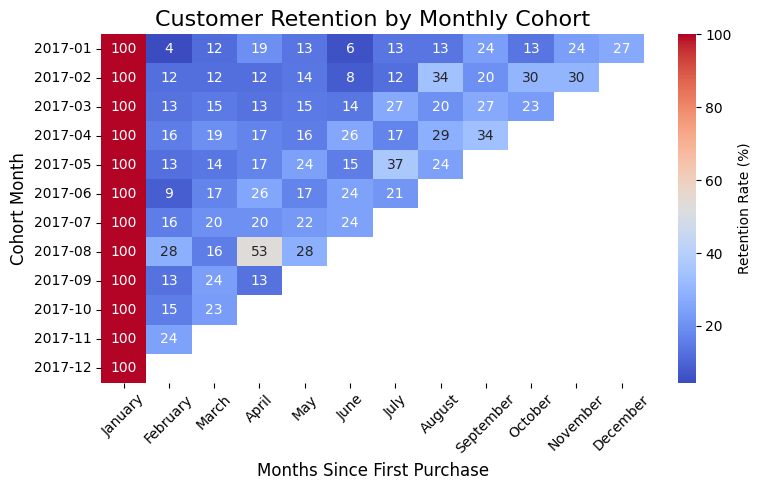

In [41]:
# Plot the heatmap
month_names = [calendar.month_name[i+1 % 12] for i in range(len(cohort_pivot.columns))]
plt.figure(figsize=(8, 5))
sns.heatmap(
    cohort_pivot,
    annot=True,
    fmt='.0f',  # Show as integers (e.g., percentages without decimals)
    cmap='coolwarm',
    cbar_kws={'label': 'Retention Rate (%)'},
    xticklabels=month_names  # Set the x-axis labels as month names
)
plt.title('Customer Retention by Monthly Cohort', fontsize=16)
plt.xlabel('Months Since First Purchase', fontsize=12)
plt.ylabel('Cohort Month', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Observations:
* Retention Consistency: Cohorts that started in January 2017 (and in subsequent months) show consistent retention values around 100% for the first few months, meaning customers who made their first purchase during these months returned in subsequent months at high rates.
* Retention Decline Over Time: As months progress, retention rates generally start to decline. For example, customers who first purchased in January 2017 have a significant drop in retention by months 5, 6, and beyond. Similarly, for most cohorts, retention rates tend to fall as the months pass, indicating that while initial interest might be high, sustaining customer engagement tends to be a challenge.
* January 2017 Cohort: The cohort that started in January 2017 shows relatively strong retention up to month 5 (with values around 13-19), suggesting that customers who made their first purchase early on in the year were more likely to stay engaged for a longer period.
* Cohort Growth: Some months, like July 2017, show a spike in retention (the "53" in the cohort for that month). This could indicate a high level of re-engagement or strong product or marketing influence during that period.
*Larger Drops in Later Cohorts: For the later months (e.g., September and beyond), there is more variability in retention, with some months showing larger drops in retention. This could be due to a variety of factors like seasonality, shifts in product offerings, or marketing efforts that didn't sustain the earlier growth.

Conclusions:
* Customer Retention is Strongest Early On: Customers from early cohorts (January-March 2017) show a good retention rate for the first few months. This suggests that efforts in these early stages, such as good onboarding or initial customer experience, are effective in keeping users engaged.
* Retention Strategies Needed for Later Stages: As time progresses, a noticeable drop in retention occurs. To maintain long-term engagement, the company might need to implement strategies focused on customer loyalty, re-engagement, or retention programs after the initial months.
* Month-Specific Variations: The variation in retention, especially in months like July 2017, suggests that marketing efforts, seasonality, or product changes could play a significant role in customer retention. Identifying the factors influencing these spikes and drops could be helpful in fine-tuning marketing and product strategies.
* Focus on Improving Retention Post-Initial Months: The overall decline after the first few months indicates that while customer acquisition might be working well, keeping those customers engaged over time needs more attention, either through loyalty programs, targeted offers, or better product engagement.

## Funnel Analysis Preparation

### Prepare Customer-Level Data

In [43]:
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')

# Group by Customer ID to get unique customer metrics
customer_orders = df.groupby('Customer ID').agg({
    'Order ID': 'count',           # Total number of orders
    'Sales': 'sum',                # Total sales per customer
    'Profit': 'sum',               # Total profit per customer
    'Order Date': ['min', 'max']   # First and last purchase dates
}).reset_index()

# Rename columns for clarity
customer_orders.columns = [
    'Customer ID', 'Total Orders', 'Total Sales',
    'Total Profit', 'First Purchase', 'Last Purchase'
]

# Calculate customer tenure
customer_orders['Customer Tenure Days'] = (
    customer_orders['Last Purchase'] - customer_orders['First Purchase']
).dt.days

# Display first few rows
customer_orders.head()

,Customer ID,Total Orders,Total Sales,Total Profit,First Purchase,Last Purchase,Customer Tenure Days
0,AA-10315,11,5563.560,-362.8825,2014-03-31,2017-06-29,1186
1,AA-10375,15,1056.390,277.3824,2014-04-21,2017-12-11,1330
2,AA-10480,12,1790.512,435.8274,2014-05-04,2017-04-15,1077
3,AA-10645,18,5086.935,857.8033,2014-06-22,2017-11-05,1232
4,AB-10015,6,886.156,129.3465,2014-02-18,2016-11-10,996


### Create Funnel Stages

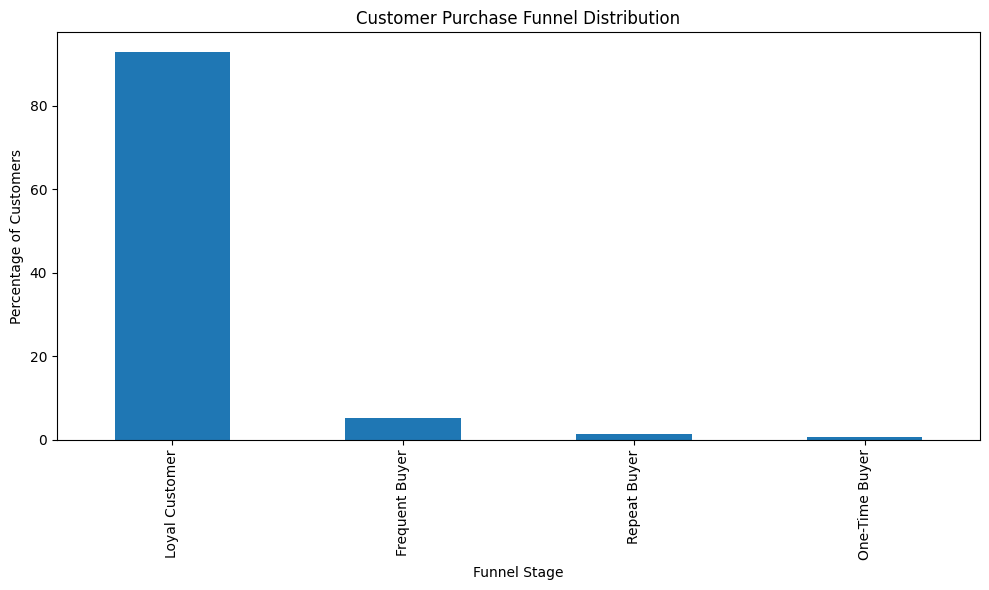

Funnel Stage
Loyal Customer    92.938209
Frequent Buyer     5.170240
Repeat Buyer       1.261034
One-Time Buyer     0.630517
Name: proportion, dtype: float64


In [44]:
# Define funnel stage classification function
def classify_funnel_stage(orders):
    if orders == 1:
        return 'One-Time Buyer'
    elif orders == 2:
        return 'Repeat Buyer'
    elif orders <= 4:
        return 'Frequent Buyer'
    else:
        return 'Loyal Customer'

# Add funnel stage to customer orders
customer_orders['Funnel Stage'] = customer_orders['Total Orders'].apply(classify_funnel_stage)

# Calculate funnel stage distribution
funnel_distribution = customer_orders['Funnel Stage'].value_counts(normalize=True) * 100

# Visualize funnel distribution
plt.figure(figsize=(10, 6))
funnel_distribution.plot(kind='bar')
plt.title('Customer Purchase Funnel Distribution')
plt.xlabel('Funnel Stage')
plt.ylabel('Percentage of Customers')
plt.tight_layout()
plt.show()

# Print distribution percentages
print(funnel_distribution)

### Segment Analysis

<Figure size 1200x600 with 0 Axes>

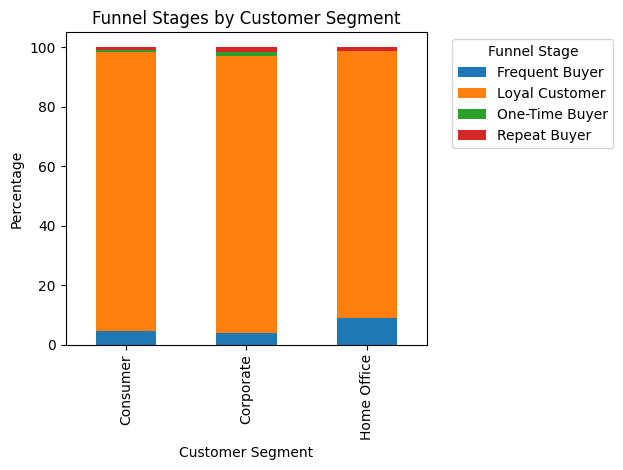

Funnel Stage  Frequent Buyer  Loyal Customer  One-Time Buyer  Repeat Buyer
Segment                                                                   
Consumer            4.645477       93.887531        0.488998      0.977995
Corporate           3.813559       93.220339        1.271186      1.694915
Home Office         8.783784       89.864865        0.000000      1.351351


In [45]:
# Merge segment information
segment_analysis = df.groupby(['Customer ID', 'Segment'])['Order ID'].count().reset_index()
segment_analysis['Funnel Stage'] = segment_analysis['Order ID'].apply(classify_funnel_stage)

# Create segment funnel breakdown
segment_funnel = pd.crosstab(
    segment_analysis['Segment'],
    segment_analysis['Funnel Stage'],
    normalize='index'
) * 100

# Visualize segment funnel
plt.figure(figsize=(12, 6))
segment_funnel.plot(kind='bar', stacked=True)
plt.title('Funnel Stages by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Percentage')
plt.legend(title='Funnel Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print segment funnel percentages
print(segment_funnel)

### Detailed Segment Analysis

In [46]:
# Detailed analysis of each segment
def segment_detailed_analysis(df):
    # Calculate key metrics by segment
    segment_metrics = df.groupby('Segment').agg({
        'Sales': ['mean', 'sum'],
        'Profit': ['mean', 'sum'],
        'Order ID': 'count'
    }).reset_index()

    segment_metrics.columns = [
        'Segment', 'Avg Sales', 'Total Sales',
        'Avg Profit', 'Total Profit', 'Total Orders'
    ]

    return segment_metrics

# Perform segment analysis
segment_detailed = segment_detailed_analysis(df)
print(segment_detailed)

       Segment   Avg Sales   Total Sales  Avg Profit  Total Profit  \
0     Consumer  223.733644  1.161401e+06   25.836873   134119.2092   
1    Corporate  233.823300  7.061464e+05   30.456667    91979.1340   
2  Home Office  240.972041  4.296531e+05   33.818664    60298.6785   

   Total Orders  
0          5191  
1          3020  
2          1783  


Key Observations and Insights:

* The funnel stages show the progression of customers from one-time buyers to loyal customers
* We'll see the distribution of customers across different purchase frequency levels
* The segment analysis reveals how different customer segments behave in terms of: Purchase frequency, Sales volume, Profitability

## Segmentation analysis

### Step 1: Customer-Level Aggregation

In [47]:
# Customer Segmentation Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

data = df.copy()

# Aggregate data to create customer-level features
customer_features = data.groupby('Customer ID').agg({
    'Sales': 'sum',           # Total sales per customer
    'Profit': 'sum',          # Total profit per customer
    'Order ID': 'count',      # Number of orders
    'Quantity': 'sum',        # Total items purchased
    'Discount': 'mean'        # Average discount received
}).reset_index()

# Rename columns for clarity
customer_features.columns = [
    'Customer ID',
    'Total Sales',
    'Total Profit',
    'Order Frequency',
    'Total Quantity',
    'Avg Discount'
]

# Display first few rows of aggregated customer features
print("\nCustomer-Level Features:")
print(customer_features.head())


Customer-Level Features:
  Customer ID  Total Sales  Total Profit  Order Frequency  Total Quantity  \
0    AA-10315     5563.560     -362.8825               11              30   
1    AA-10375     1056.390      277.3824               15              41   
2    AA-10480     1790.512      435.8274               12              36   
3    AA-10645     5086.935      857.8033               18              64   
4    AB-10015      886.156      129.3465                6              13   

   Avg Discount  
0      0.090909  
1      0.080000  
2      0.016667  
3      0.063889  
4      0.066667  


### Step 2: Feature Preparation and Scaling

In [48]:

# Select features for clustering
features_for_clustering = customer_features[[
    'Total Sales',
    'Total Profit',
    'Order Frequency',
    'Total Quantity',
    'Avg Discount'
]]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

### Step 3: Determine Optimal Number of Clusters (Elbow Method)

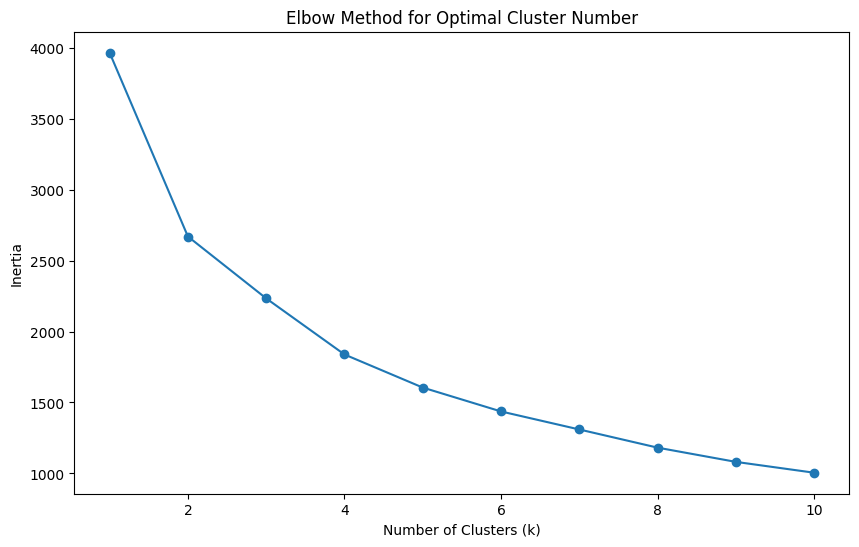

In [49]:
# Calculate inertia for different numbers of clusters
inertias = []
max_clusters = 10

for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), inertias, marker='o')
plt.title('Elbow Method for Optimal Cluster Number')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

### Step 4: Perform Clustering

In [50]:
# Choose number of clusters based on elbow method (let's say 4)
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to customer features
customer_features['Cluster'] = cluster_labels

### Step 5: Segment Analysis

In [51]:
# Analyze characteristics of each cluster
cluster_summary = customer_features.groupby('Cluster').agg({
    'Total Sales': ['mean', 'min', 'max'],
    'Total Profit': ['mean', 'min', 'max'],
    'Order Frequency': ['mean', 'min', 'max'],
    'Total Quantity': ['mean', 'min', 'max'],
    'Avg Discount': ['mean', 'min', 'max']
})

print("\nCluster Summary:")
print(cluster_summary)


Cluster Summary:
          Total Sales                      Total Profit                        \
                 mean       min        max         mean        min        max   
Cluster                                                                         
0         3923.168796   659.138  11789.630   349.588902 -2797.9635  1677.3931   
1         1925.477093    22.328   6979.180   358.764722  -571.9678  1990.4244   
2         1545.782205     4.833   9351.212   -96.015632 -6626.3895   850.1591   
3        10271.393364  6121.114  25043.050  2558.536471 -1980.7393  8981.3239   

        Order Frequency         Total Quantity          Avg Discount  \
                   mean min max           mean min  max         mean   
Cluster                                                                
0             18.971660  12  37      73.696356  47  150     0.166255   
1              9.387097   2  19      34.454839   4   62     0.094345   
2              8.350515   1  16      31.134021   2   6

### Step 6: Visualization

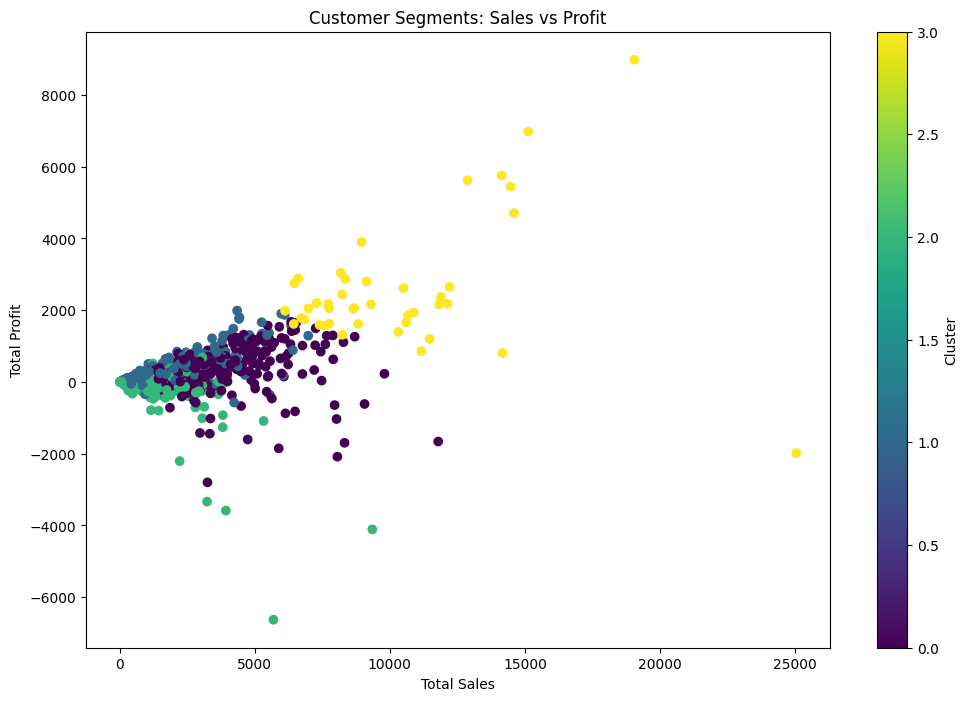

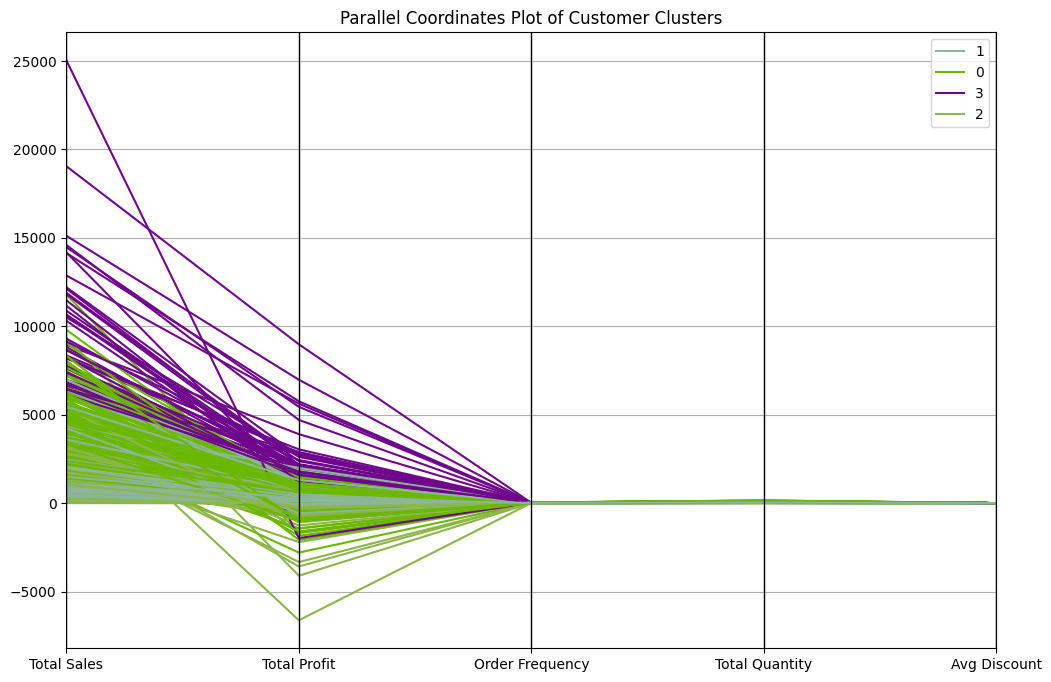

In [52]:
# Scatter plot of clusters based on Total Sales and Total Profit
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    customer_features['Total Sales'],
    customer_features['Total Profit'],
    c=customer_features['Cluster'],
    cmap='viridis'
)
plt.title('Customer Segments: Sales vs Profit')
plt.xlabel('Total Sales')
plt.ylabel('Total Profit')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Additional Visualization: Parallel Coordinates Plot
plt.figure(figsize=(12, 8))
pd.plotting.parallel_coordinates(
    customer_features.reset_index(),
    'Cluster',
    cols=[
        'Total Sales',
        'Total Profit',
        'Order Frequency',
        'Total Quantity',
        'Avg Discount'
    ]
)
plt.title('Parallel Coordinates Plot of Customer Clusters')
plt.show()

### Step 7: Segment Profiling

In [53]:
# Create detailed segment profiles
def segment_profile(cluster_number):
    cluster_data = customer_features[customer_features['Cluster'] == cluster_number]
    print(f"\nCluster {cluster_number} Profile:")
    print("Number of Customers:", len(cluster_data))
    print("\nKey Characteristics:")
    for column in ['Total Sales', 'Total Profit', 'Order Frequency', 'Total Quantity', 'Avg Discount']:
        print(f"{column}:")
        print(f"  Mean: {cluster_data[column].mean():.2f}")
        print(f"  Median: {cluster_data[column].median():.2f}")
        print(f"  Standard Deviation: {cluster_data[column].std():.2f}")

# Generate profiles for each cluster
for i in range(num_clusters):
    segment_profile(i)


Cluster 0 Profile:
Number of Customers: 247

Key Characteristics:
Total Sales:
  Mean: 3923.17
  Median: 3368.09
  Standard Deviation: 1833.68
Total Profit:
  Mean: 349.59
  Median: 340.71
  Standard Deviation: 637.25
Order Frequency:
  Mean: 18.97
  Median: 18.00
  Standard Deviation: 4.61
Total Quantity:
  Mean: 73.70
  Median: 69.00
  Standard Deviation: 18.41
Avg Discount:
  Mean: 0.17
  Median: 0.17
  Standard Deviation: 0.06

Cluster 1 Profile:
Number of Customers: 310

Key Characteristics:
Total Sales:
  Mean: 1925.48
  Median: 1640.73
  Standard Deviation: 1392.53
Total Profit:
  Mean: 358.76
  Median: 248.38
  Standard Deviation: 394.54
Order Frequency:
  Mean: 9.39
  Median: 10.00
  Standard Deviation: 3.38
Total Quantity:
  Mean: 34.45
  Median: 36.00
  Standard Deviation: 13.06
Avg Discount:
  Mean: 0.09
  Median: 0.10
  Standard Deviation: 0.05

Cluster 2 Profile:
Number of Customers: 194

Key Characteristics:
Total Sales:
  Mean: 1545.78
  Median: 1254.87
  Standard Devi